In [1]:
import warnings
warnings.filterwarnings('ignore')
import sys

sys.path.append('/data/yosef2/users/chenling/scVI/')
import scvi
print(scvi.__version__)

import os
os.getcwd()

import logging
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from hyperopt import hp

from scvi.inference import UnsupervisedTrainer, AlternateSemiSupervisedTrainer, SemiSupervisedTrainer
from scvi.models import VAE, SCANVI

from scvi.dataset.anndataset import AnnDatasetFromAnnData
import scanpy as sc
from anndata import read_h5ad
from anndata import AnnData

import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline

n_epochs = 150
save_path = '../data/'
from copy import deepcopy

0.5.0


In [2]:
# tissue = 'lung'
tissue = 'exopancreas'
# tissue = 'endopancreas'
# tissue = 'bladder'
# tissue = 'muscle'

In [3]:
adata = read_h5ad('%s.scVI.h5ad'%tissue)

In [4]:
adata.obs.columns

Index(['10X_plate', 'BA_nM', 'NovaSeqRun', 'additional_notes',
       'anatomical_position', 'barcode', 'batch', 'bead_cleanup',
       'cDNA_dilute', 'cDNA_prep_person', 'excluded', 'investigator',
       'lib_prep_date', 'library_prep', 'method', 'n_genes', 'plate',
       'primary_sort', 'sex', 'sort_direction', 'sort_order', 'subjectid',
       'tissue', 'well', 'well_group', 'louvain_scvi', 'compartment_pred',
       'Epithelial', 'Endothelial', 'Stromal', 'Immune', 'Epithelial_label',
       'Endothelial_label', 'Stromal_label', 'Immune_label', 'comp_pred',
       'S_score', 'G2M_score', 'phase', 'leiden_scvi', 'compartments'],
      dtype='object')

In [5]:
sc.tl.leiden(adata, key_added="leiden_scvi", resolution=1)

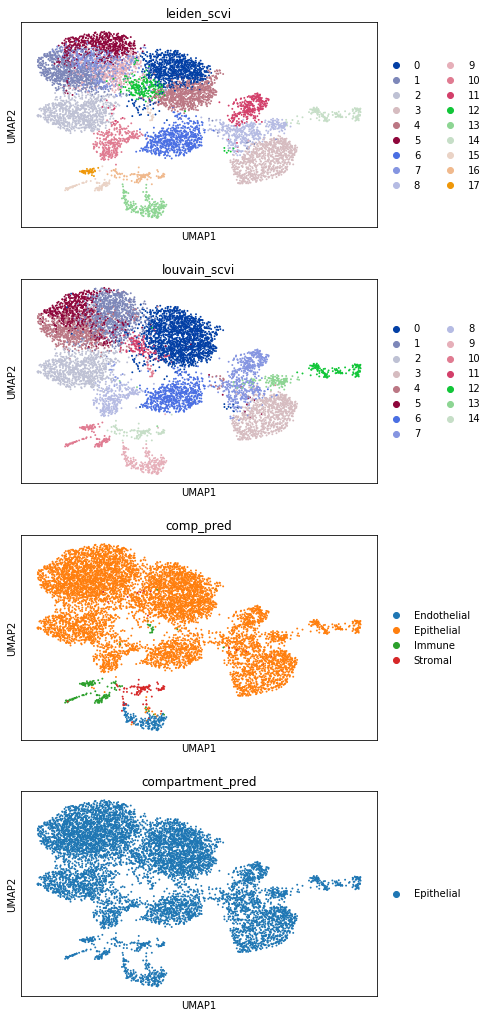

In [6]:
sc.pl.umap(adata, color=['leiden_scvi','louvain_scvi','comp_pred', 'compartment_pred'],ncols=1)

# For each cluster take majority vote for splitting the compartments

In [7]:
def clustercomp(List): 
    x, k = np.unique(List,return_counts=True)
    if np.max(k)/np.sum(k)>0.8: 
        return max(set(List), key = List.count) 
    else:
        return('mixed')

In [8]:
compartments = deepcopy(adata.obs['comp_pred'].values.astype(str))
for i in np.unique(adata.obs['leiden_scvi']):
    res = clustercomp(list(compartments[adata.obs['leiden_scvi']==i]))
    compartments[adata.obs['leiden_scvi']==i] = np.repeat(res, np.sum(adata.obs['leiden_scvi']==i))

In [9]:
adata.obs['compartments'] = compartments

... storing 'compartments' as categorical


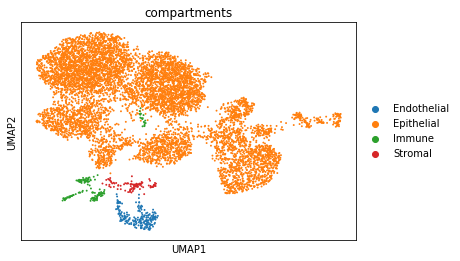

In [10]:
sc.pl.umap(adata, color=['compartments'],ncols=1,save='%s.compartments.pdf'%tissue )


In [11]:
split_data = {}
for x in np.unique(compartments):
    split_data[x] = adata[adata.obs['compartments']==x,:]
    print(x, split_data[x].shape)

Endothelial (226, 21301)
Epithelial (7642, 21301)
Immune (157, 21301)
Stromal (100, 21301)


In [12]:
tissue

'exopancreas'

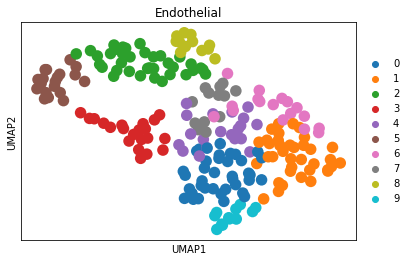

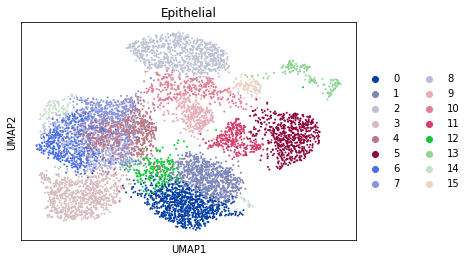

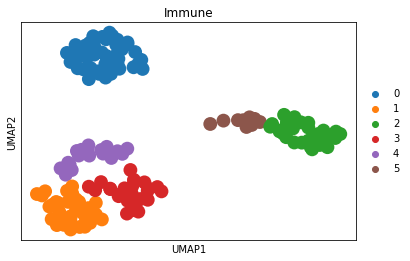

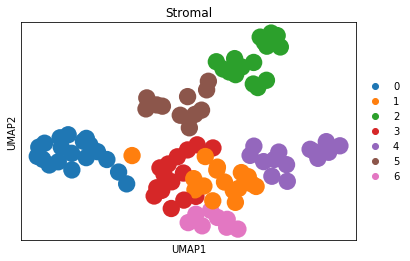

In [13]:
for x in split_data.keys():
    sc.pp.neighbors(split_data[x], n_neighbors=10, n_pcs=30, use_rep="X_scvi")
    sc.tl.umap(split_data[x])
    sc.tl.leiden(split_data[x], key_added="leiden_scvi_split", resolution=1)
    sc.pl.umap(split_data[x], color=['leiden_scvi_split'],title=x)
    split_data[x].write("%s.%s.h5ad"%(tissue,x))

# differential expression

In [14]:
split_data.keys()

dict_keys(['Endothelial', 'Epithelial', 'Immune', 'Stromal'])

In [15]:
split_data['Immune'].shape

(157, 21301)

In [16]:
split_data.keys()

dict_keys(['Endothelial', 'Epithelial', 'Immune', 'Stromal'])

Endothelial


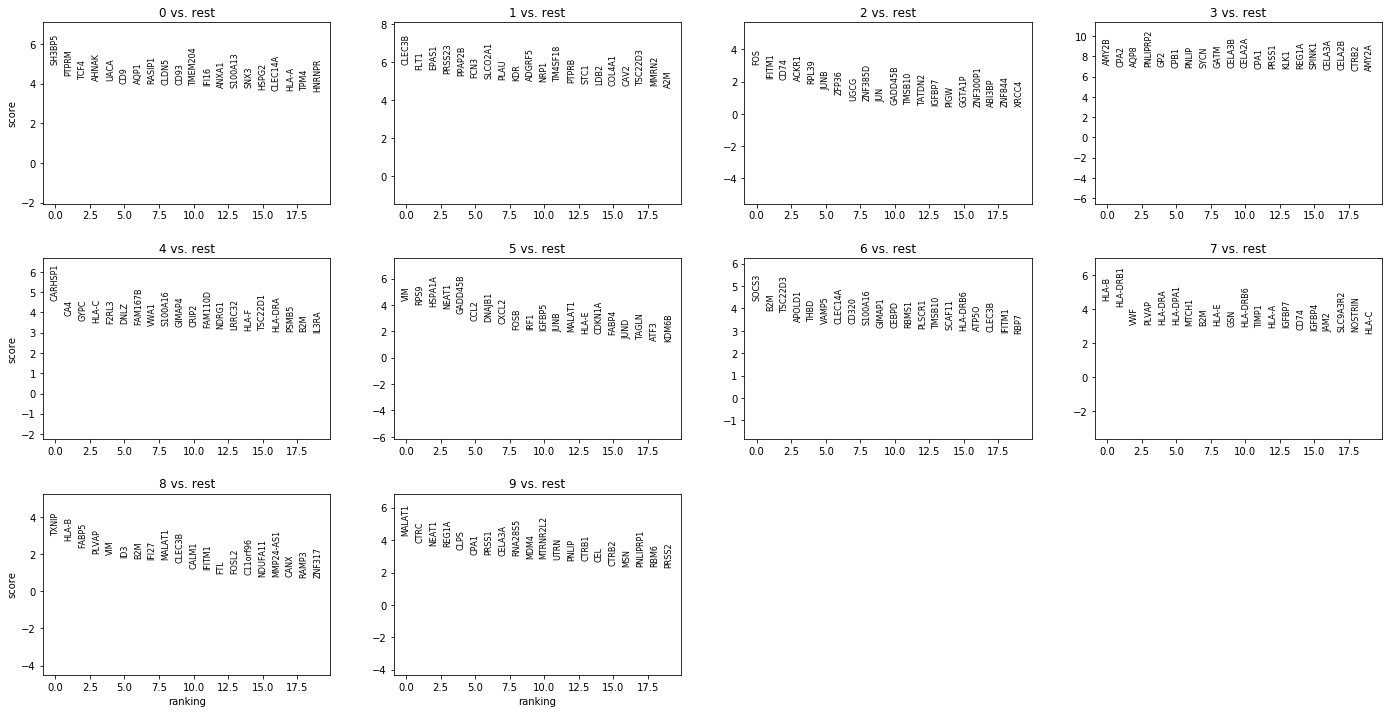

Epithelial


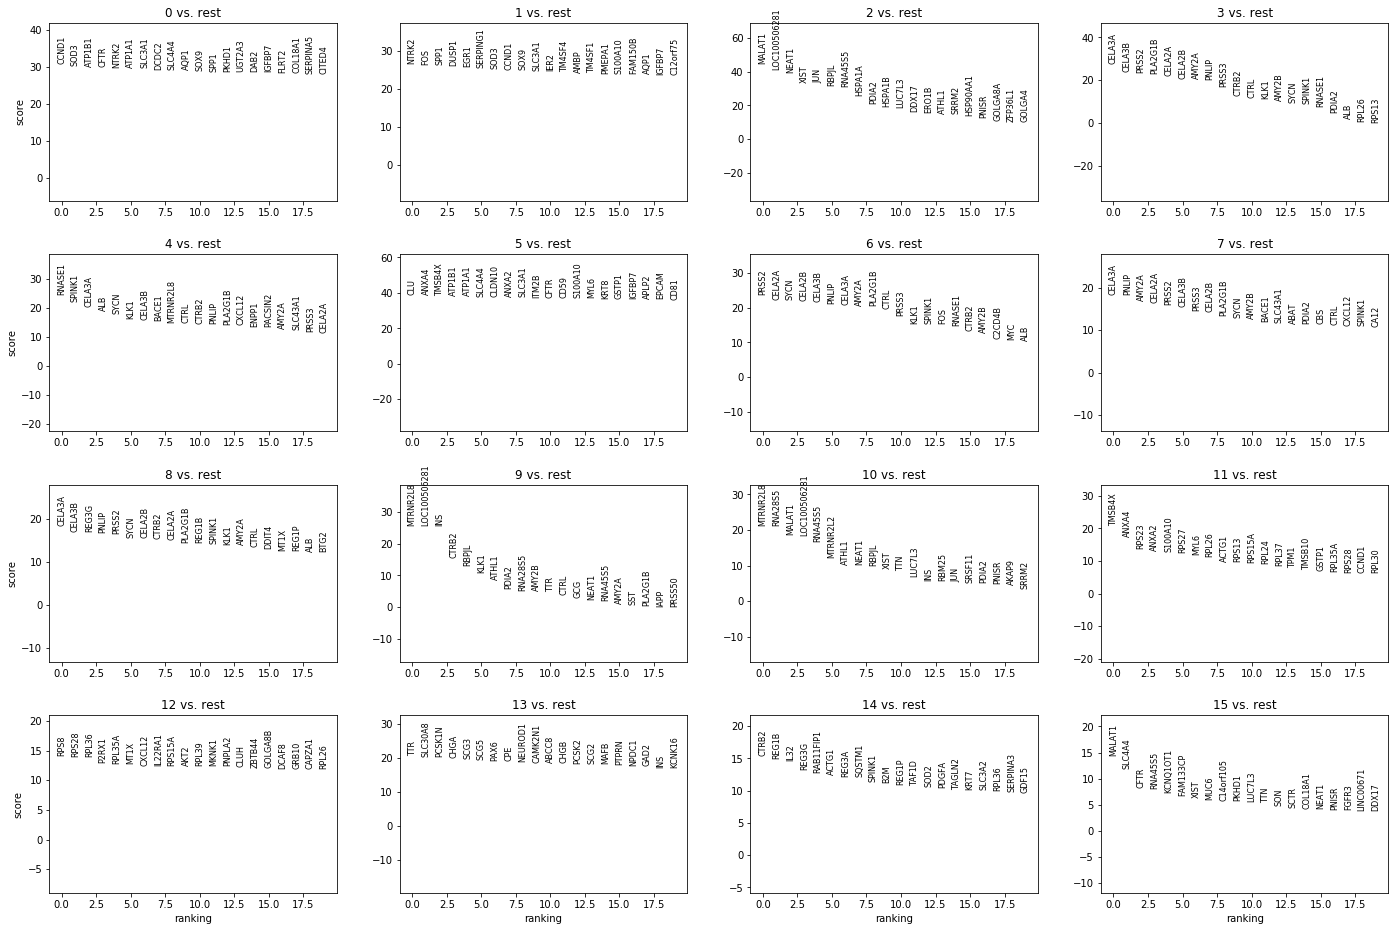

Immune


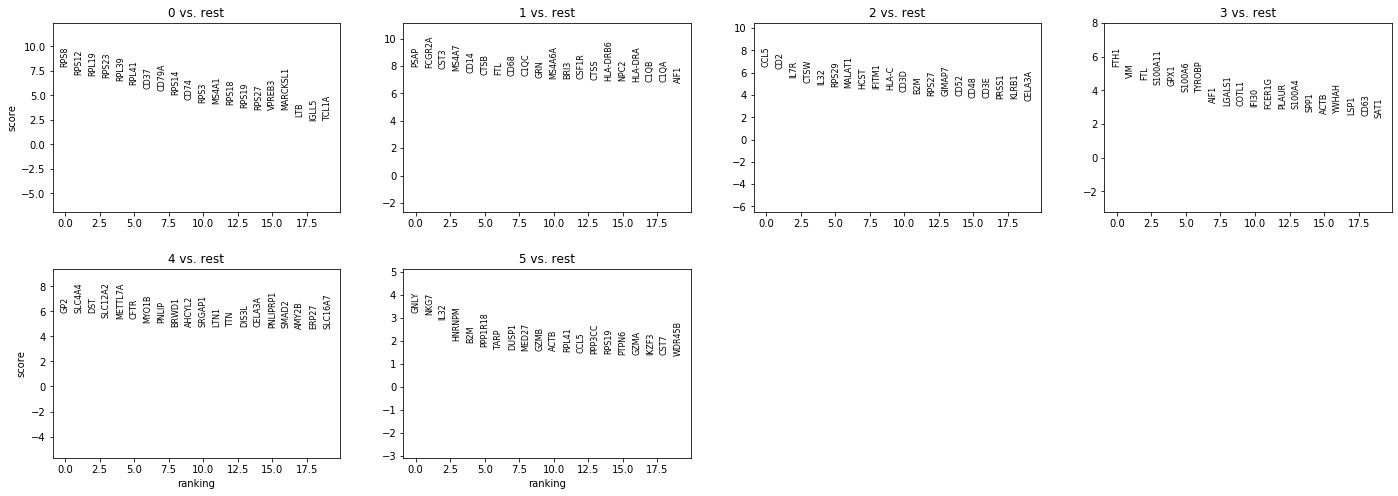

Stromal


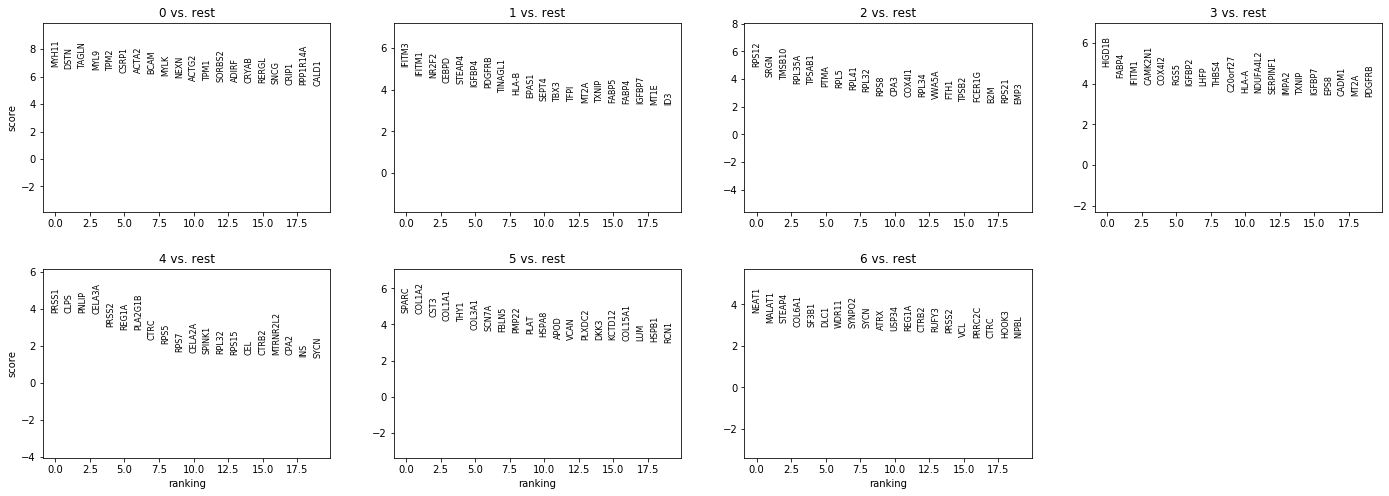

In [17]:
for x in split_data.keys():
    print(x)
    sc.pp.filter_genes(split_data[x], min_counts=1)
    sc.pp.filter_genes_dispersion(split_data[x], min_disp=0.01)
    sc.tl.rank_genes_groups(
        split_data[x],
        "leiden_scvi_split",
        method="wilcoxon",
        use_raw=False,
        key_added="rank_genes_comp_wilcox",
        n_genes=split_data[x].shape[1]
    )
    sc.pl.rank_genes_groups(
        split_data[x], key="rank_genes_comp_wilcox", sharey=False
    )
    result = split_data[x].uns['rank_genes_comp_wilcox']
    groups = result['names'].dtype.names
    sapiens_rank_genes_scores = pd.DataFrame(
        {group + '_' + key[:1]: result[key][group]
        for group in groups for key in ['names', 'scores','pvals']})

    sapiens_rank_genes_scores.to_csv('%s.%s.wilcoxon.csv'%(tissue,x))

In [18]:
sapiens_rank_genes_scores

,0_n,0_s,0_p,1_n,1_s,1_p,2_n,2_s,2_p,3_n,...,3_p,4_n,4_s,4_p,5_n,5_s,5_p,6_n,6_s,6_p
0,MYH11,6.734770,1.641892e-11,IFITM3,5.105404,3.300882e-07,RPS12,4.903256,9.426076e-07,HIGD1B,...,0.000001,PRSS1,3.814590,0.000136,SPARC,4.667138,0.000003,NEAT1,3.608356,0.000308
1,DSTN,6.550256,5.743853e-11,IFITM1,4.672902,2.969732e-06,SRGN,4.193389,2.748175e-05,FABP4,...,0.000018,CLPS,3.794723,0.000148,COL1A2,4.592888,0.000004,MALAT1,3.125548,0.001775
2,TAGLN,6.550256,5.743853e-11,NR2F2,4.578880,4.674723e-06,TMSB10,3.920725,8.828305e-05,IFITM1,...,0.000079,PNLIP,3.774855,0.000160,CST3,4.423174,0.000010,STEAP4,3.093784,0.001976
3,MYL9,6.506324,7.701201e-11,CEBPD,4.343824,1.400233e-05,RPL35A,3.662164,2.500939e-04,CAMK2N1,...,0.000080,CELA3A,3.745054,0.000180,COL1A1,4.200424,0.000027,COL6A1,2.934966,0.003336
4,TPM2,6.400887,1.544765e-10,STEAP4,4.278009,1.885724e-05,TPSAB1,3.554038,3.793640e-04,COX4I2,...,0.000084,PRSS2,3.049685,0.002291,THY1,4.147388,0.000034,SF3B1,2.922260,0.003475
5,CSRP1,6.277878,3.432255e-10,IGFBP4,4.146378,3.377760e-05,PTMA,3.427108,6.100456e-04,RGS5,...,0.000087,REG1A,2.890744,0.003843,COL3A1,3.707193,0.000210,DLC1,2.909554,0.003619
6,ACTA2,6.260305,3.842252e-10,PDGFRB,4.089965,4.314389e-05,RPL5,3.398902,6.765703e-04,IGFBP2,...,0.000098,PLA2G1B,2.885777,0.003904,SCN7A,3.670068,0.000242,WDR11,2.858733,0.004253
7,BCAM,6.198800,5.689517e-10,TINAGL1,3.854909,1.157726e-04,RPL41,3.224961,1.259900e-03,LHFP,...,0.000104,CTRC,2.314582,0.020636,FBLN5,3.595818,0.000323,SYNPO2,2.858733,0.004253
8,MYLK,6.067004,1.303180e-09,HLA-B,3.770289,1.630584e-04,RPL32,3.055721,2.245203e-03,THBS4,...,0.000115,RPS5,2.096038,0.036079,PMP22,3.521568,0.000429,SYCN,2.846027,0.004427
9,NEXN,5.939602,2.857154e-09,EPAS1,3.624555,2.894595e-04,RPS8,2.820665,4.792418e-03,C20orf27,...,0.000317,RPS7,1.673850,0.094160,PLAT,3.500354,0.000465,ATRX,2.757089,0.005832


In [19]:
adata.write('%s.scVI.h5ad'%tissue)